# Image Classification on Stanford 'Cars' Dataset
**CPE695 Final Project**

**By: Tyler Bryk, Michael Eng, Gabriella Tantillo**

In [ ]:
# Load Dependencies
import os
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

In [ ]:
# Mount Google Drive and Locate Stanford Data
cwd = os.getcwd()
directory = cwd + '/new_cars'
trainDir = directory + '/train'
testDir  = directory + '/test'

**Loading & Transforming the Data**

In the following module, we will load the Stanford dataset from Google Drive, and normalize the data. We will use PyTorch's [Torchvision Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) library to apply transforms on the dataset, [Torchvision datasets.ImageFolder()](https://pytorch.org/docs/stable/torchvision/datasets.html) and [Torchvision util.data.DataLoader()](https://pytorch.org/docs/stable/data.html) to load the raw jpeg images into a library. First, we will create a simple transform which resizes all of the images to a standard size (256x256), converts the image to a tensor object, and then normalizes each tensor object. The normalization values are in the format of (mean[ch1], mean[ch2], mean[ch3]) and (std[ch1], std[ch2], std[ch3]). In this initial step, the mean and standard deviation values are initialized based on the recommended values from PyTorch. We will fine tune the normalization values in a later step to more accurately fit out data. Next, the ImageFolder() method is called with the DataLoader() to open each of the transformed images and load them into a single training or testing library. 

In [ ]:
# Training Data Transform
transformTr = transforms.Compose([transforms.Resize((256,256)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                       (0.229, 0.224, 0.225))])

# Testing Data Transform
transformTe = transforms.Compose([transforms.Resize((256,256)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                       (0.229, 0.224, 0.225))])

# Create Training and Testing Set from Transforms
trainData = datasets.ImageFolder(trainDir, transform=transformTr)
testData  = datasets.ImageFolder(testDir,  transform=transformTe)

# Load Image Files into a Library
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=128, shuffle=True)
testLoader  = torch.utils.data.DataLoader(testData,  batch_size=32,  shuffle=True)

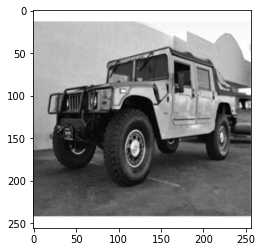

In [ ]:
# Example of plotting an image -- This can be deleted later
plt.imshow((trainData[0][0]).numpy()[0], cmap='gray')
plt.show()

# Buidling a Deep Residual Network Model

**1. Defining the Model**

In this step, we will build a Deep Residual Network (ResNet) using PyTorch's [Resnet model](https://pytorch.org/hub/pytorch_vision_resnet/). The resnet is a type of deep residual neural network which comes in many flavors based on the desired input size and number of hidden layers. Additionally, the resnet comes either as a standalone model, or a pre-trained model which is trained on the [ImageNet Database](http://www.image-net.org). In our application, we will select the pre-trained model with 34 layers. Selecting the pre-trained variant will help us achieve better model generalization to new data, meaning that the model should repsond well to our raw training data. After initializing the model, we then use PyTorch's [nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to apply a linear tranform to the fully-connected (fc) layers based on the input size of the images, and the number of classes which is 196. Next, we will set the models scoring criterion to follow a cross-entropy loss function, using PyTorch's [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function. We then define the optimizing method as PyTorch's [optim.SGD()](https://pytorch.org/docs/stable/optim.html). Although PyTorch offers a wide variety of optimzers, we will choose SGD for now because the team is familar with that particluar optimizer from CPE695. Additionally, we will arbitrarily select a learning rate of 0.01 and momentum of 0.9, these parameters can be tuned in a later step. For now, PyTorch offers a learning rate scheduler as part of the [optim library](https://pytorch.org/docs/stable/optim.html), so we will use a function to reduce the learning rate once our parameters have stopped improving. This function will take our SGD optimizer and observe the number of epochs where the model improves, the patience flag will allow the model to remain constant for 3 epochs before enagaging, and the threshold flag defines the amount of variance to be considered when evaluating to epochs. Now that we have our resnet model setup, we will begin fitting it with our training dataset. 

In [ ]:
# Deep Residual Network Model
resnet = models.resnet34(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

**2. Fitting the Model**

In [ ]:
epochs = 10
steps = 0

resnet.to('cuda')
resnet.train()
for epoch in range(epochs):
    runningLoss = 0
    
    # Iterate over Training Data
    for step, (inputs, labels) in enumerate(trainLoader):
        steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()                 # Set Param Gradients to Zero
        outputs = resnet.forward(inputs)      # Feed-forward Pass
        loss = criterion(outputs, labels)     # Calculate Loss
        loss.backward()                       # Backpropagation Pass
        optimizer.step()                      # Update Parameters
        runningLoss += loss.item()            # Update Total Loss
        
    print(f"No. epochs: {epoch+1}, Training Loss: {round(runningLoss/100,3)}")

In [ ]:
correct = 0
total = 0

resnet.to('cuda')
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = resnet(images)
        _, prediction = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

print(f"Test Accuracy: {round(100*correct/total,3)}%")

Test Accuracy: 75.998%
